In [1]:
!pip install pandas
!pip install numpy
!pip install ua_parser user_agents
!pip install matplotlib
!pip install lime
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=653f1f19d60657515480ab3e0a9b044aef538b2d405140a74bd79cac9265504c
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 6.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
dataset_path = "/content/gdrive/MyDrive/ml/data"

# Common Functions

In [4]:
from ua_parser.user_agent_parser import Parse as parse_ua

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import re
import zipfile

## URL directory extracting

In [5]:
IMG_DIRS = set(["image/", "settings/", "discountLabel/", "productImage/"])
JSON_DIRS = set(["province/", "productType/", "specialSaleSlide/"])
URL_DIRS = set(["filter", "ajaxFilter", "contactUs", "search", "ajaxSearch", "blog", "articleList"])
INVALID_EXTS = set(["ir", "visin", "8inch", "5inch", "1inch"])

def remove_params(url):
    if "?" in url:
        return url.partition("?")[0]

    return url

def extract_extension(url):
    ext = None
    if url.rfind(".") > url.rfind("/"):
        # extract extention
        ext = url.rpartition(".")[2]

        if ext.endswith("~"):
            # fix incorrect extension
            ext = ext[:-1]

        if not ext.isalnum() or not ext.islower() or len(ext) > 5 or len(ext) < 2 or ext in INVALID_EXTS:
            # drop invalid extension
            ext = None

    return ext

def extract_directory(url, track_mobile=False):
    if not url.startswith("/"):
        # extenral url - no processing
        if track_mobile:
            return (url, None, False)
        else:
            return (url, None)

    url = url[1:] # strip leading slash

    if url.startswith("http"):
        # external url - no processing
        if track_mobile:
            return (url, None, False)
        else:
            return (url, None)

    isMobile = False
    if url == "m":
        # redirect to index
        url = ""
        isMobile = True
    elif url.startswith("m/"):
        # strip mobile prefix
        url = url[2:]
        isMobile = True

    if url.startswith("/"):
        # strip extra slash
        url = url[1:]

    url = remove_params(url)
    ext = extract_extension(url)

    if url == "" or url == "index":
        dir = "/"
    elif "/" in url:
        # extract directory before first slash encountered
        dir = f"{url.partition('/')[0]}/"
    elif url in URL_DIRS:
        # redirect urls to popular dirs
        dir = f"{url}/"
    elif url.startswith("amp_preconnect_polyfill"):
        # replace annoying AMP preconnect url
        dir = "amp_preconnect_polyfill"
    else:
        # keep url as is
        dir = url

    if ext is None and "/" in url:
        # manually resolve known extensions in certain dirs
        if dir in IMG_DIRS:
            ext = "img"
        elif dir in JSON_DIRS:
            ext = "json"
        elif dir == "siteMap/" or dir == "sitemap/":
            ext = "xml"

    if track_mobile:
        return (dir, ext, isMobile)
    else:
        return (dir, ext)

## Referer domain extracting

In [6]:
protocol_regex = re.compile(r"^(?:\/?[^\/]+:\/\/)?([^\/]+)\/?.*")
domain_regex = re.compile(r"(?:www\.)?([^\.]*[a-zA-Z][^\.]*\.(?:[^\.:]{2,}|[^\.:]{2,3}\.[^\.]{2}))$")

def extract_domain(ref):
    if pd.isna(ref):
        return ref

    m = protocol_regex.match(ref)
    if not m:
        return ref

    url = m.group(1)
    m = domain_regex.search(url)
    if not m:
        return url

    return m.group(1).lower()

## User Agent parsing

In [7]:
def extract_ua(ua):
    if pd.isna(ua):
        return ua

    ua_parsed = parse_ua(ua)

    ua_agent = ua_parsed['user_agent']
    dev = ua_parsed['device']

    ua_fam = ua_agent['family']
    dev_fam = dev['family']
    dev_brand = dev['brand']

    if dev_fam == 'Other':
        ua = ua_fam
    elif dev_fam == 'Spider':
        ua = f"_{ua_fam}"
    elif ua_fam == 'Android' or 'Android' in dev_brand:
        ua = 'Android'
    else:
        ua = f"{ua_fam.replace(' WebView', '')} ({dev_brand})"

    return ua

In [8]:
# library imports
import csv
import sys

In [9]:
# # extract access log from zip to /content
# zip = zipfile.ZipFile(f"{dataset_path}/zanbil.zip", "r")
# zip.extractall()
# zip.close()

In [10]:
# # https://gist.github.com/joswr1ght/c2e08f520933bb36c0b19aa0dcb6a173

# # accesslog2csv: Convert default, unified access log from Apache, Nginx
# # servers to CSV format.
# #
# # Original source by Maja Kraljic, July 18, 2017
# # Modified by Joshua Wright to parse all elements in the HTTP request as
# # different columns, December 16, 2019
# # Modified by Konstantinos Papakostas to allow for misformatted HTTP requests
# # and handle file IO more efficiently, April 2, 2021

# def convert_to_csv(log_file_name, csv_file_name):
#     pattern = re.compile(r'(?P<host>\S+).(?P<rfc1413ident>\S+).(?P<user>\S+).\[(?P<datetime>\S+ \+[0-9]{4})]."(?P<httpverb>[A-Z]+) (?P<url>.+) (?P<httpver>HTTP\/\S+)" (?P<status>[0-9]{3}) (?P<size>[0-9]+|-) "(?P<referer>.*)" "(?P<useragent>.*)" "(?P<unknown>.*)"')

#     with open(log_file_name, 'r') as log:
#         with open(csv_file_name, 'w') as out:
#             csv_out = csv.writer(out)
#             csv_out.writerow(['host', 'ident', 'user', 'time', 'verb', 'url', 'httpver', 'status', 'size', 'referer', 'useragent', 'unknown'])

#             for line in log:
#                 m = pattern.match(line)
#                 if m is None:
#                     # error matching
#                     print(line)
#                 else:
#                     result = m.groups()
#                     csv_out.writerow(result)

In [11]:
# # convert access log to comma separated values
# convert_to_csv("./zanbil.log", "./zanbil.csv")

In [12]:
# # compress CSV to zip
# zip = zipfile.ZipFile(f"{dataset_path}/zanbil_csv.zip", 'w', zipfile.ZIP_DEFLATED)
# zip.write('./zanbil.csv')
# zip.close()

In [13]:
# extract CSV from zip to /content
zip = zipfile.ZipFile(f"{dataset_path}/zanbil_csv.zip", "r")
zip.extractall()
zip.close()

## DataFrame creation

In [14]:
# create pandas DataFrame in memory
df = pd.read_csv("zanbil.csv")

In [15]:
# 'ident' field -- always equal to "-", remove it
del df['ident']

# 'user' field -- almost always equal to "-" (only 2 exceptions), remove it
del df['user']

# 'httpver' field -- the http version used by the client
df['httpver'] = df['httpver'].astype('category')
# there's an entry with an invalid 'httpver' value, remove it
valid_versions = ['HTTP/1.0','HTTP/1.1']
df = df[df['httpver'].isin(valid_versions)]
df['httpver'] = df['httpver'].replace(valid_versions,[False,True])
df['httpver'] = df['httpver'].astype('bool')
df.rename(columns={'httpver': 'uses_http_1_1'}, inplace=True)

# 'time' field -- the timestamp of the request, convert to datetime
df['time'] = pd.to_datetime(df['time'], format="%d/%b/%Y:%H:%M:%S %z")

# 'status' field -- the http status code returned by the server
df['status'] = df['status'].astype('int16')

# 'size' field -- the size of the server's response
df['size'] = df['size'].astype('int32')

# 'host' field -- the IP of the client
df['host'] = df['host'].astype('category')
df.rename(columns={'host': 'ip'}, inplace=True)

# 'verb' field -- the http method used (GET/POST/HEAD/...) by the client
df['verb'] = df['verb'].astype('category')
df.rename(columns={'verb': 'method'}, inplace=True)

# 'referer' field -- the previous url visited by the client
df['referer'] = df['referer'].astype('category')

# 'useragent' field -- the UserAgent value sent by the client
df['useragent'] = df['useragent'].astype('category')

# 'unknown' field -- IP-like, not sure what it means
df['unknown'] = df['unknown'].astype('category')

df.info()

<ipython-input-15-d9b189e1247c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['httpver'] = df['httpver'].replace(valid_versions,[False,True])
<ipython-input-15-d9b189e1247c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['httpver'] = df['httpver'].astype('bool')
<ipython-input-15-d9b189e1247c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10365075 entries, 0 to 10365075
Data columns (total 10 columns):
 #   Column         Dtype                                
---  ------         -----                                
 0   ip             category                             
 1   time           datetime64[ns, pytz.FixedOffset(210)]
 2   method         category                             
 3   url            object                               
 4   uses_http_1_1  bool                                 
 5   status         int16                                
 6   size           int32                                
 7   referer        category                             
 8   useragent      category                             
 9   unknown        category                             
dtypes: bool(1), category(5), datetime64[ns, pytz.FixedOffset(210)](1), int16(1), int32(1), object(1)
memory usage: 451.1+ MB


In [16]:
# save DataFrame as a gzip compressed parquet
df.to_parquet(f"{dataset_path}/zanbil_requests.parquet.gzip", compression='gzip')

## Visualize access patterns

In [17]:
def plot_top_value_counts(counts, k):
    name = '# of requests'
    top = pd.DataFrame(counts.head(k))
    top.columns = [name]
    top.index.name = 'origin'

    if k < len(counts):
        top.reset_index(inplace=True)
        top.loc[k] = ['others', counts[k:].sum()]
        top.set_index('origin', inplace=True)
        title = f'Top {k} sources of origin'
    else:
        title = 'Sources of origin'

    top.sort_values(by=[name]).plot(kind='barh', logx=True, title=title, figsize=(15, 10))

def plot_top_series(series, k):
    plot_top_value_counts(series.value_counts(), k)

### IPs

In [18]:
df['ip'].value_counts().describe(percentiles=[.5, .75, .9, .99, .999])

count    258593.000000
mean         40.082582
std         995.401437
min           1.000000
50%           3.000000
75%          33.000000
90%          86.000000
99%         407.000000
99.9%      1423.408000
max      353483.000000
Name: ip, dtype: float64

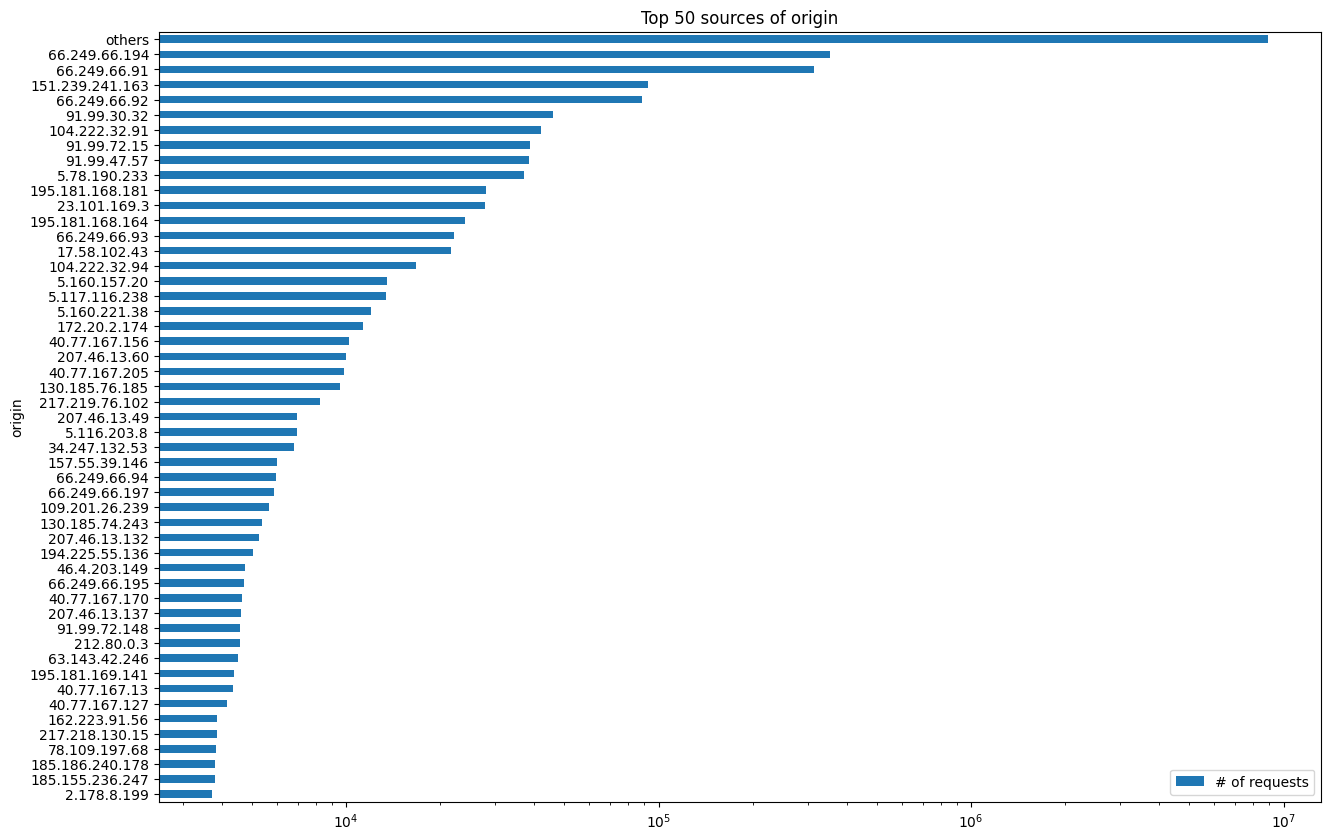

In [19]:
# TODO: maybe group IPs based on subnet masks?
plot_top_series(df['ip'], 50)

### Time

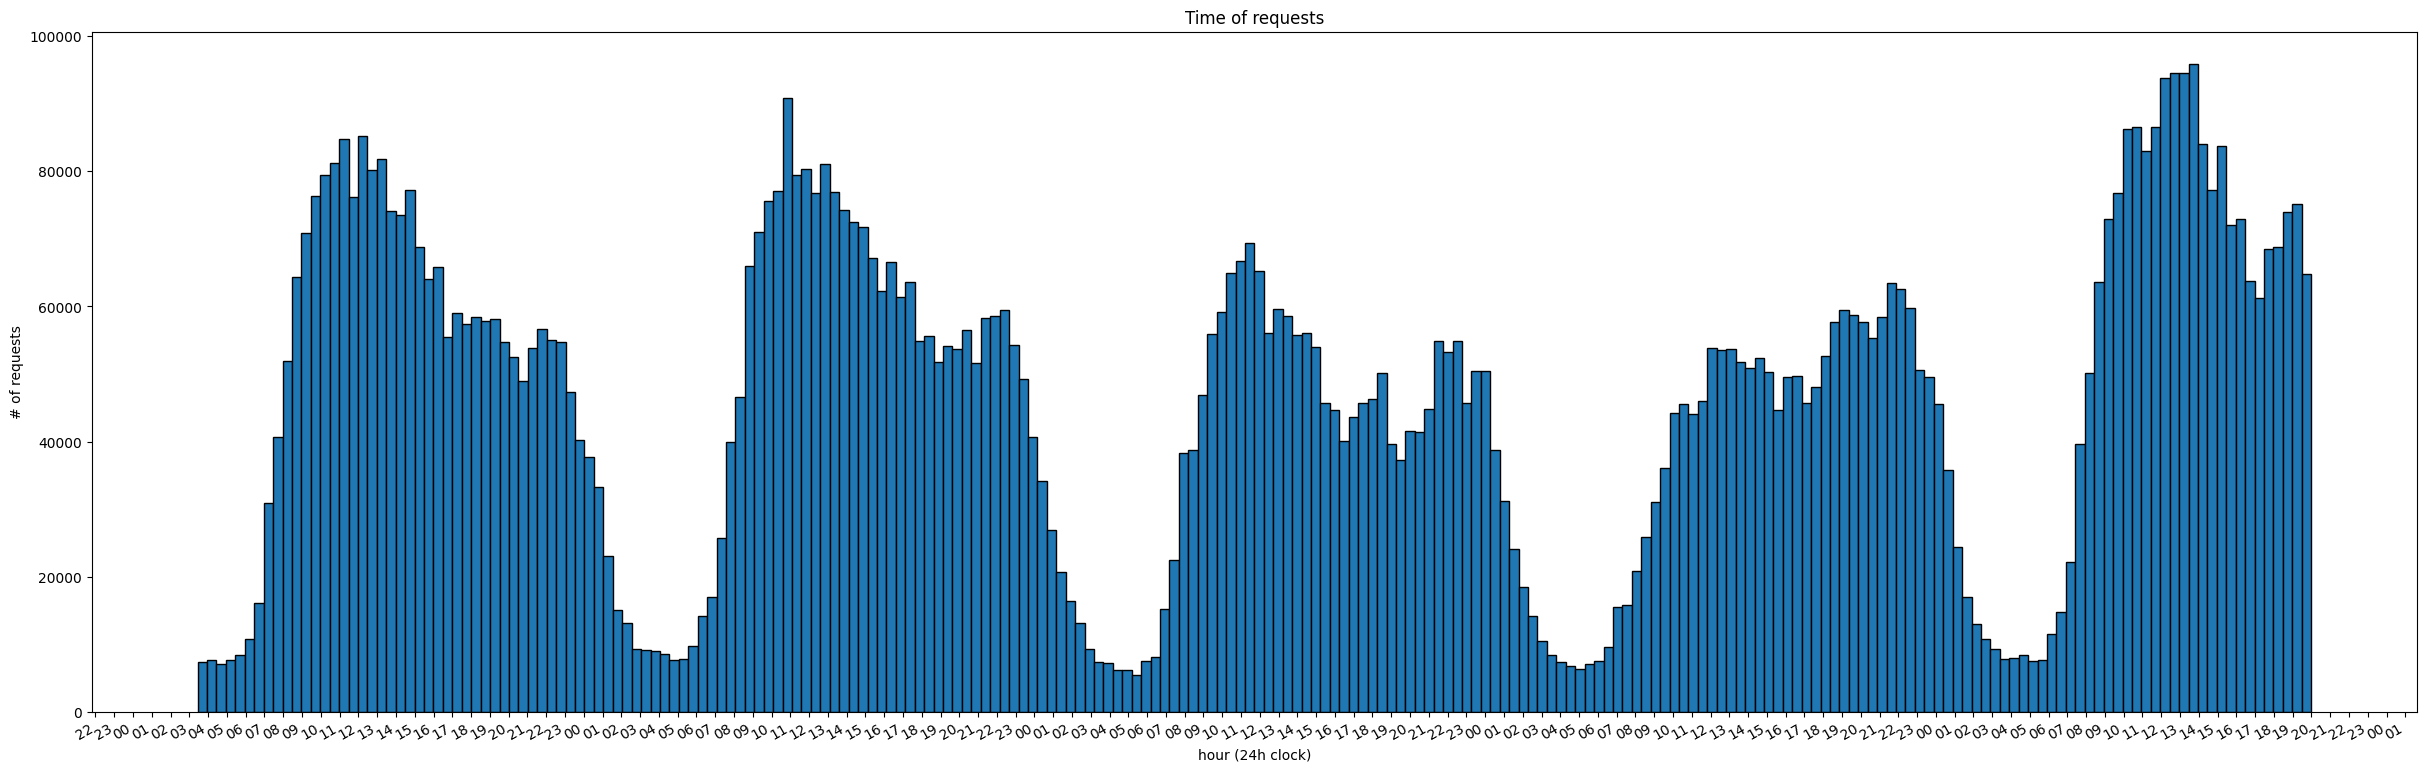

In [20]:
from matplotlib.dates import date2num, DateFormatter, HourLocator

dates = df['time'].apply(lambda t: date2num(t.to_pydatetime())).tolist()

start_time = df['time'].iloc[0]
end_time = df['time'].iloc[-1]
diff = pd.Timedelta(end_time - start_time)
(days, hours, *_) = diff.components
hours += days * 24

fig, ax = plt.subplots(1,1, figsize=(30,10))
ax.hist(dates, bins=2*hours, edgecolor='black')

ax.xaxis.set_major_locator(HourLocator())
ax.xaxis.set_major_formatter(DateFormatter("%H", tz=df.iloc[0]['time'].tz))

ax.set_xlabel("hour (24h clock)")
ax.set_ylabel("# of requests")
ax.title.set_text('Time of requests')

fig.autofmt_xdate()

### HTTP Method

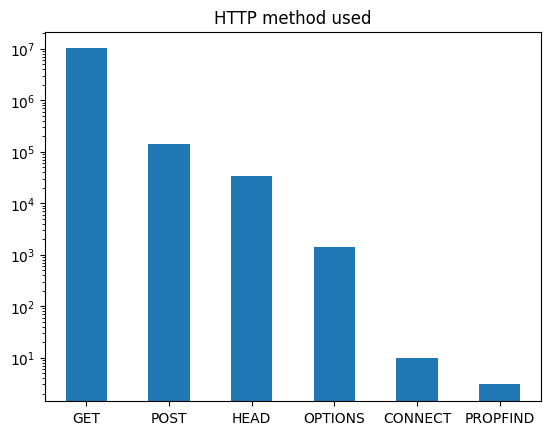

In [21]:
df['method'].value_counts().plot(kind='bar', logy=True, title='HTTP method used', rot=0);

### URLs

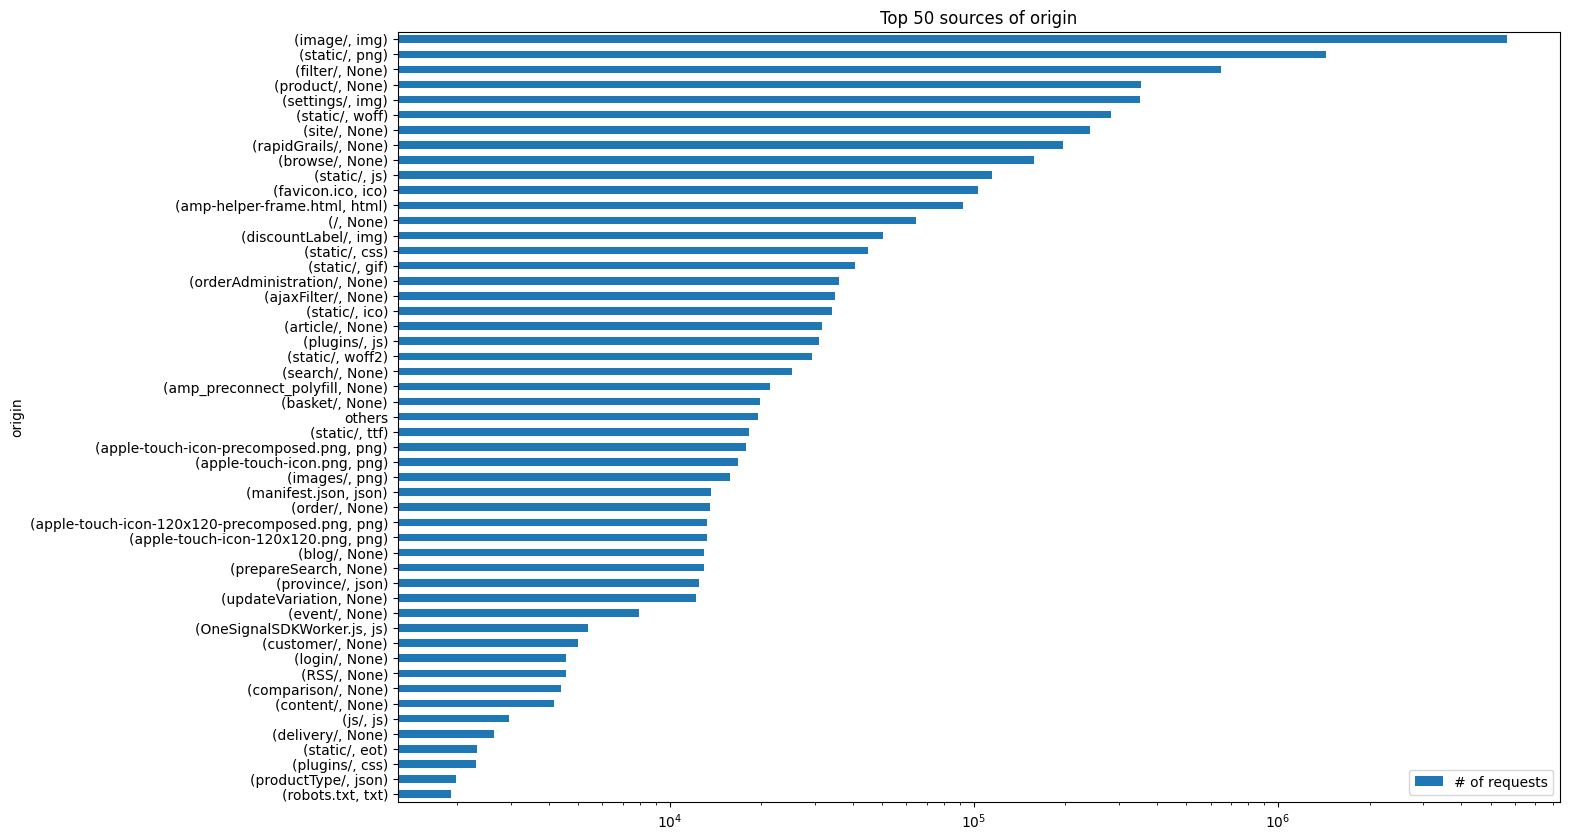

In [22]:
url_series = df['url'].apply(extract_directory)
plot_top_series(url_series, 50)

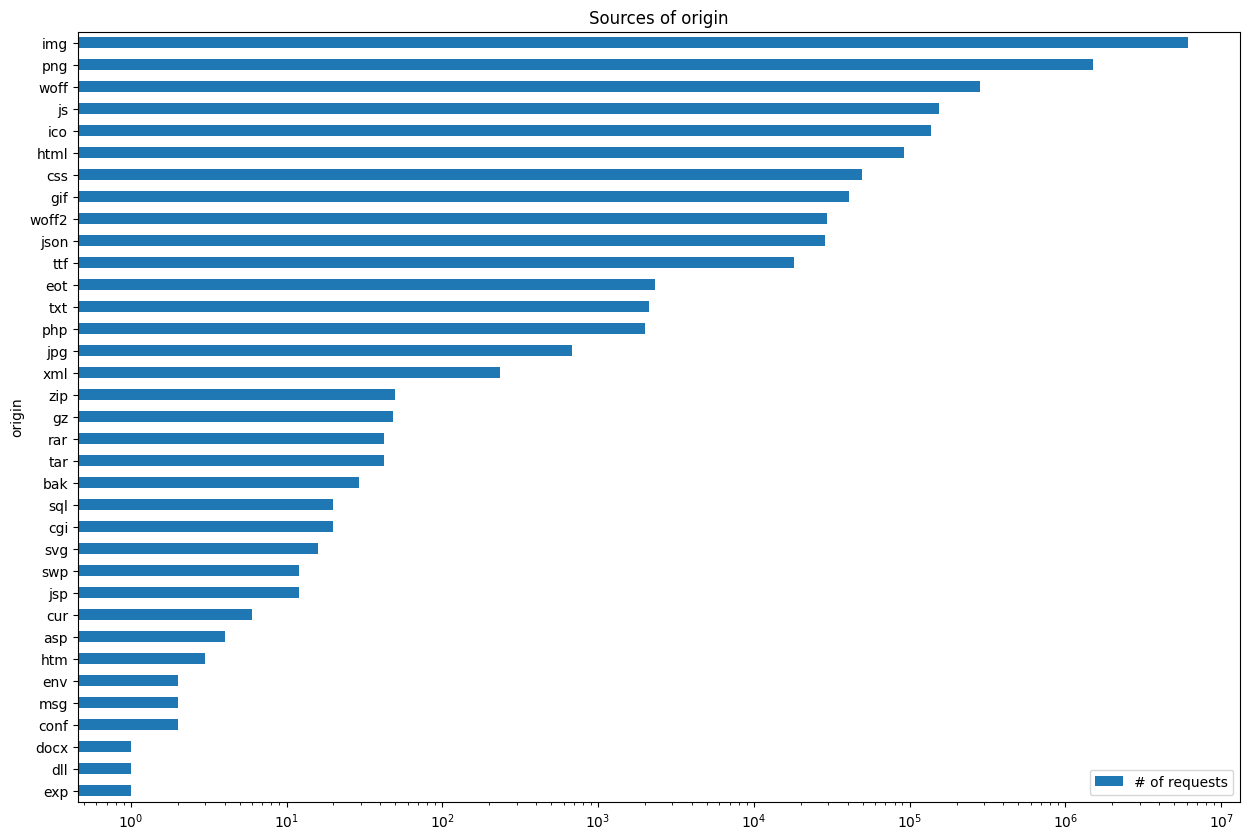

In [23]:
exts = pd.DataFrame(url_series.apply(lambda t: t[1])).iloc[:, 0]
plot_top_series(exts, 50)

### HTTP Client Version (1.1 vs 1.0)

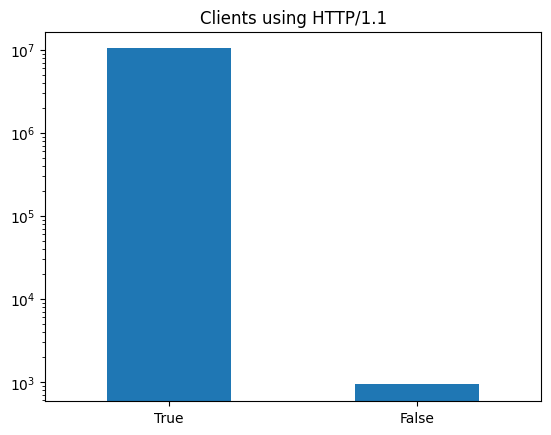

In [24]:
df['uses_http_1_1'].value_counts().plot(kind='bar', logy=True, title='Clients using HTTP/1.1', rot=0);

### HTTP Response Status Code

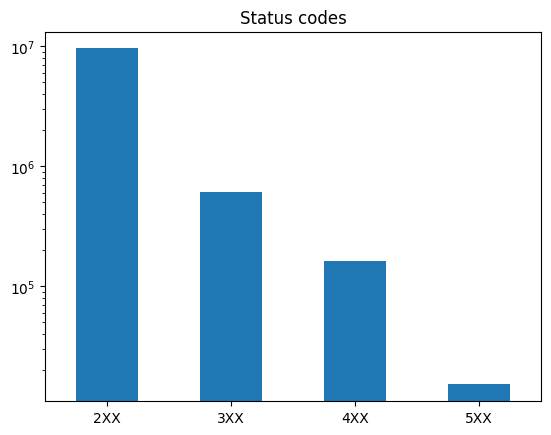

In [25]:
df['status'].apply(lambda x: f"{x // 100}XX").value_counts().plot(kind='bar', logy=True, title='Status codes', rot=0);

### HTTP Response Size

In [26]:
df['size'].describe()

count    1.036508e+07
mean     1.243319e+04
std      2.812662e+04
min      0.000000e+00
25%      2.027000e+03
50%      4.120000e+03
75%      1.155100e+04
max      1.249490e+06
Name: size, dtype: float64

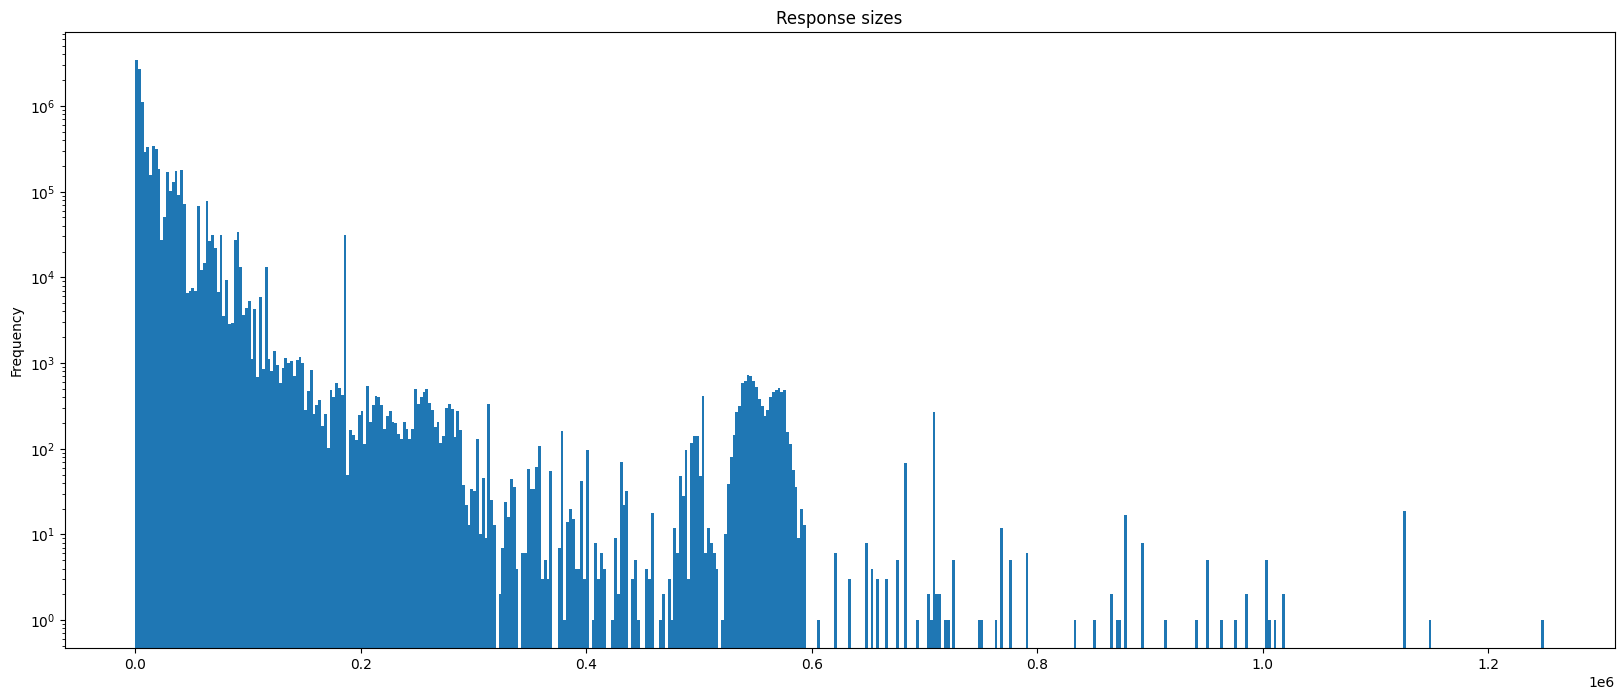

In [27]:
df['size'].plot(kind='hist', logy=True, bins=500, figsize=(20, 8), title='Response sizes');

### Referers

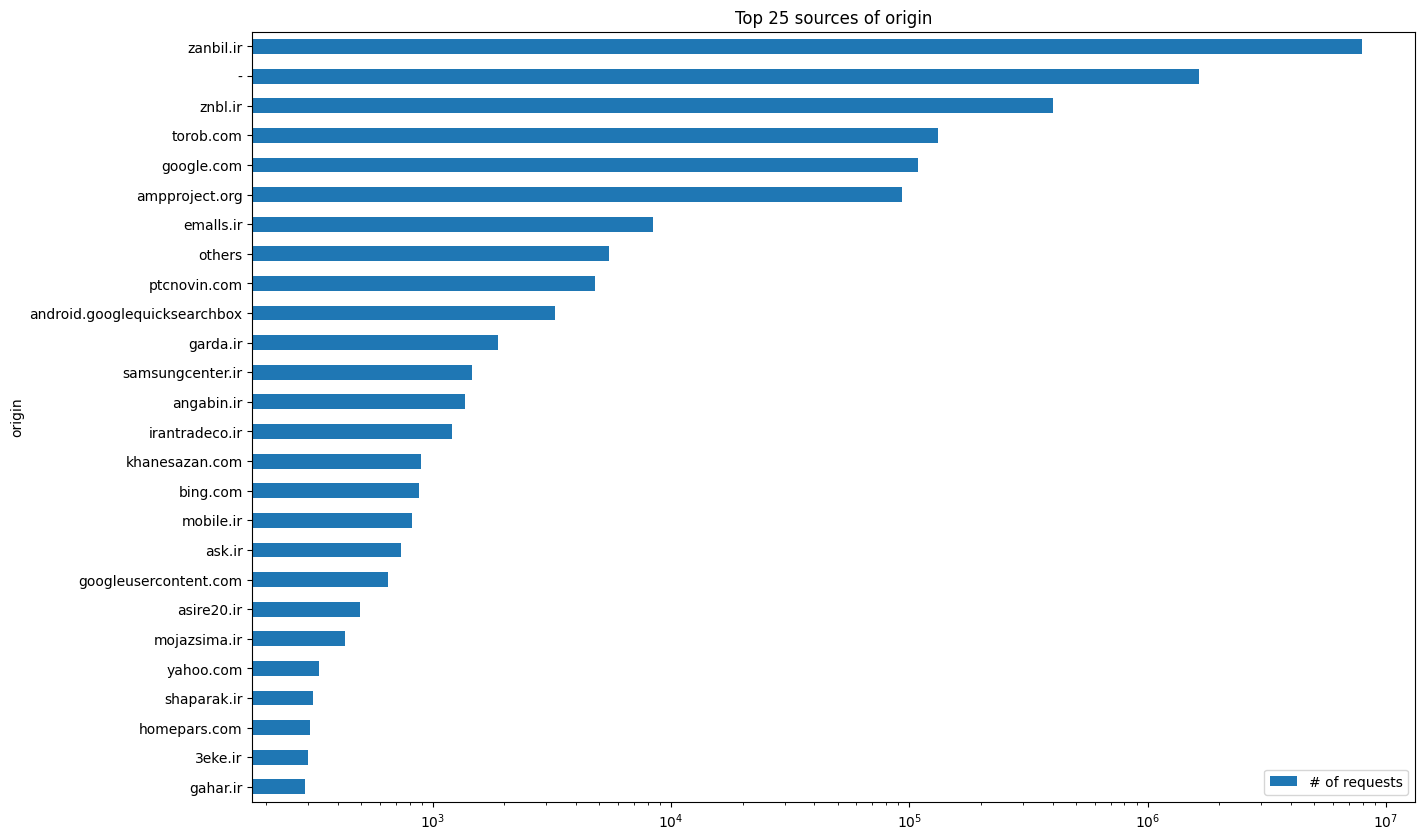

In [28]:
domain_series = df['referer'].apply(extract_domain)
plot_top_series(domain_series, 25)

### User Agents

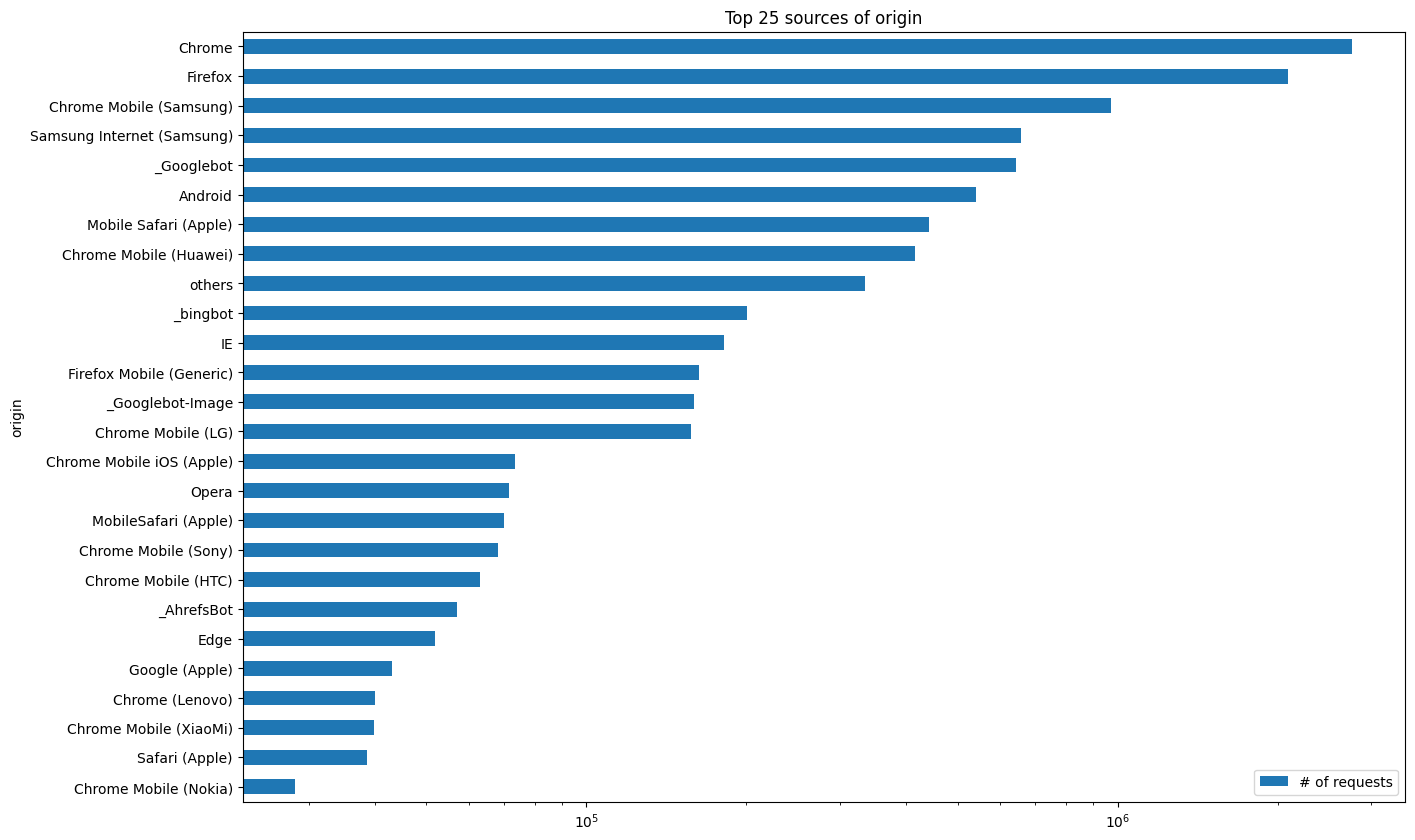

In [29]:
ua_series = df['useragent'].apply(extract_ua)
plot_top_series(ua_series, 25)

### Unknown field

In [30]:
df['unknown'].value_counts()

-               10341009
5.127.61.214         526
51.38.89.157         464
5.112.171.19         365
5.218.20.237         263
                  ...   
31.2.184.228           1
31.2.129.182           1
5.216.78.0             1
31.145.201.0           1
2.190.50.0             1
Name: unknown, Length: 1558, dtype: int64

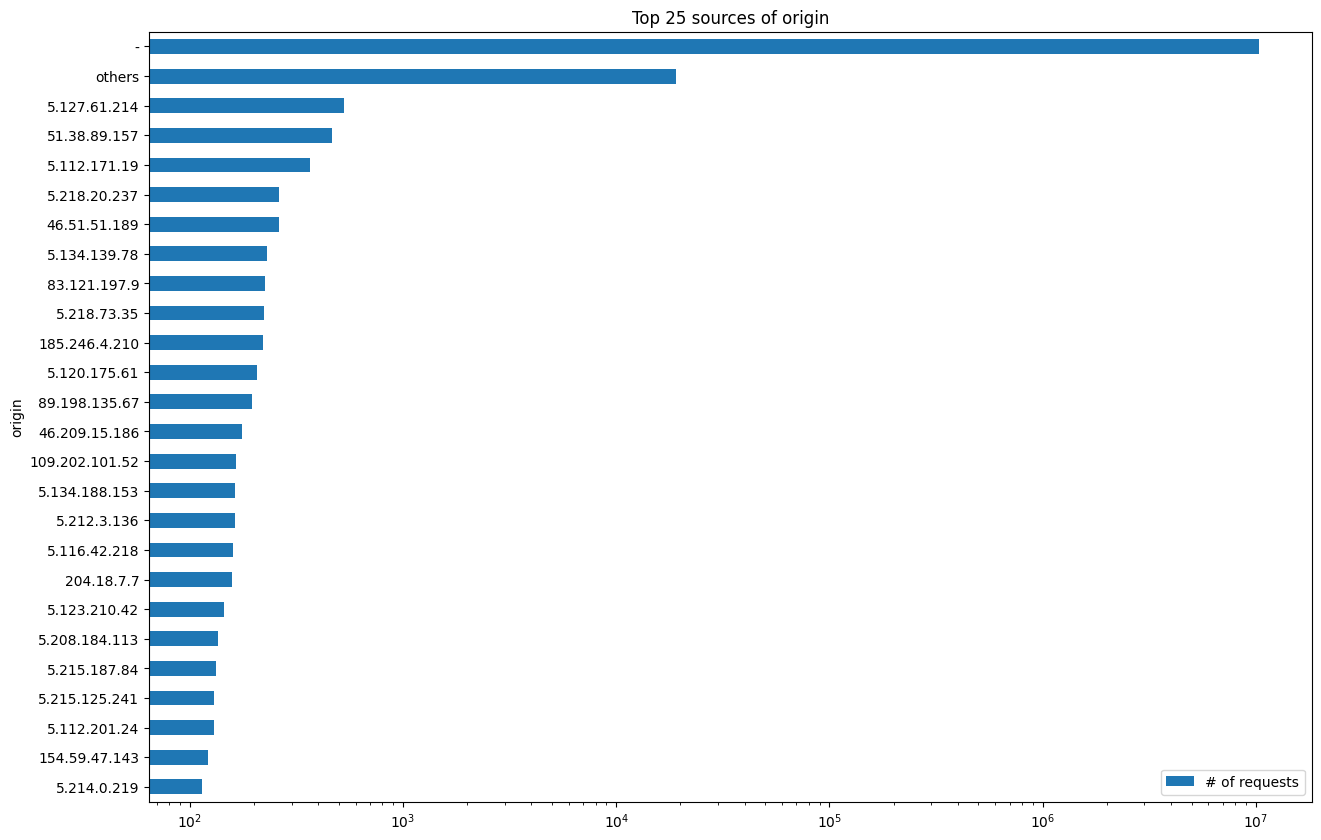

In [31]:
plot_top_series(df['unknown'], 25)

In [32]:
# import parquet as a DataFrame
df = pd.read_parquet(f"{dataset_path}/zanbil_requests.parquet.gzip")
df.head()

,ip,time,method,url,uses_http_1_1,status,size,referer,useragent,unknown
0,54.36.149.41,2019-01-22 03:56:14+03:30,GET,/filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%DB%8C...,True,200,30577,-,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,-
1,31.56.96.51,2019-01-22 03:56:16+03:30,GET,/image/60844/productModel/200x200,True,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,-
2,31.56.96.51,2019-01-22 03:56:16+03:30,GET,/image/61474/productModel/200x200,True,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,-
3,40.77.167.129,2019-01-22 03:56:17+03:30,GET,/image/14925/productModel/100x100,True,200,1696,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,-
4,91.99.72.15,2019-01-22 03:56:17+03:30,GET,/product/31893/62100/%D8%B3%D8%B4%D9%88%D8%A7%...,True,200,41483,-,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...,-


In [33]:
from enum import Enum

class Category(Enum):
    AUTOMATED = 0
    HOMEPAGE = 1
    ARTICLE = 2
    BLOG = 3
    CONTENT = 4
    EVENT = 5
    CONTACT = 6
    CAPTCHA = 7
    BROWSE = 8
    SEARCH = 9
    FILTER = 10
    COMPARISON = 11
    PRODUCT = 12
    BASKET = 13
    ORDER = 14
    CUSTOMER = 15
    ADMIN = 16
    STATIC_IMG = 17
    STATIC_JS = 18
    STATIC_CSS = 19
    STATIC_FONT = 20
    STATIC_TEXT = 21
    STATIC_JSON = 22
    STATIC_XML = 23
    AMP = 24
    RSS = 25
    ERROR = 26
    PING = 27

In [34]:
imgExts = set(["img", "png", "ico", "gif", "jpg", "svg", "cur"])
fontExts = set(["woff", "woff2", "ttf", "eot"])

articleDirs = set(["article/", "articleList/"])
contentDirs = set(["content/", "shoppingRules", "trust", "guaranteeDays", "priceGuarantee", "guarantee", "shoppingSteps", "faq", "deliveryTips", "addedValue", "paymentAndDelivery", "paymentMethods", "deliveryPrice", "content", "suppliers"])
contactDirs = set(["contactUs/", "aboutUs"])
browseDirs = set(["browse/", "enemad", "wishList/", "sidebar", "products", "big-kitchen-appliances/", "browse"])
searchDirs = set(["search/", "prepareSearch", "ajaxSearch/", "searchAutoComplete"])
filterDirs = set(["filter/", "ajaxFilter/"])
orderDirs = set(["order/", "track", "go/"])
customerDirs = set(["customer/", "login/", "j_spring_security_check", "logout/", "j_spring_security_logout"])
adminDirs = set(["rapidGrails/", "orderAdministration/", "delivery/", "productModel/", "price/", "variationGroup/", "admin", "discountNew/", "producer/", "slide/", "addedValue/", "guarantee/", "otherPriceLink/", "cultureEvent/", "paymentRequest/", "producingProduct/", "user/", "orderCollection/", "producerProductModel/", "pricingLink/", "ADMIN"])
ampDirs = set(["amp_preconnect_polyfill", "updateVariation"])
errorDirs = set(["grails-errorhandler", "errors/"])

productSubdirsProd = set(["event", "sidebar", "products"])
searchSubdirs = set(["searchAutoComplete", "prepareSearch"])
imgSubdirs = set(["enamad", "productImage"])
autoSubdirs = set(["index", "track"])
productSubdirsSite = set(["productCard", "productPrice", "productModelImages", "productAdditives", "similarProducts", "product"])

dirs = {}

def extract_category(url):
    (dir, ext, mob) = extract_directory(url, track_mobile=True)

    category = None
    if ext is not None:
        if ext in imgExts:
            category = Category.STATIC_IMG
        elif ext in fontExts:
            category = Category.STATIC_FONT
        elif ext == "js":
            category = Category.STATIC_JS
        elif ext == "css":
            category = Category.STATIC_CSS
        elif ext == "txt":
            category = Category.STATIC_TEXT
        elif ext == "json":
            category = Category.STATIC_JSON
        elif ext == "xml":
            category = Category.STATIC_XML
        else:
            category = Category.AUTOMATED
    else:
        if dir == "/":
            category = Category.HOMEPAGE
        elif dir in articleDirs:
            category = Category.ARTICLE
        elif dir == "blog/":
            category = Category.BLOG
        elif dir in contentDirs:
            category = Category.CONTENT
        elif dir == "event/":
            category = Category.EVENT
        elif dir in contactDirs:
            category = Category.CONTACT
        elif dir == "simpleCaptcha/":
            category = Category.CAPTCHA
        elif dir in browseDirs:
            category = Category.BROWSE
        elif dir in searchDirs:
            category = Category.SEARCH
        elif dir in filterDirs:
            category = Category.FILTER
        elif dir == "comparison/":
            category = Category.COMPARISON
        elif dir == "product":
            category = Category.PRODUCT
        elif dir == "basket/":
            category = Category.BASKET
        elif dir in orderDirs:
            category = Category.ORDER
        elif dir in customerDirs:
            category = Category.CUSTOMER
        elif dir in adminDirs:
            category = Category.ADMIN
        elif dir == "discountLabel/":
            category = Category.STATIC_IMG
        elif dir == "alexaGooleAnalitic":
            category = Category.STATIC_JS
        elif dir in ampDirs:
            category = Category.AMP
        elif dir == "RSS/":
            category = Category.RSS
        elif dir in errorDirs:
            category = Category.ERROR
        elif dir == "product/":
            url = url.partition("/product")[2]
            (dir, _) = extract_directory(url)
            if dir[0].isdigit():
                category = Category.PRODUCT
            elif dir == "image":
                category = Category.STATIC_IMG
            elif dir == "themes":
                category = Category.STATIC_CSS
            elif dir in productSubdirsProd:
                category = Category.PRODUCT
            else:
                category = Category.ADMIN
        elif dir == "site/":
            url = url.partition("/site")[2]
            (dir, _) = extract_directory(url)
            if dir == "alexaGooleAnalitic":
                category = Category.STATIC_JS
            elif dir in searchSubdirs:
                category = Category.SEARCH
            elif dir in imgSubdirs:
                category = Category.STATIC_IMG
            elif dir == "ping":
                category = Category.PING
            elif dir in autoSubdirs:
                category = Category.AUTOMATED
            elif dir in productSubdirsSite:
                category = Category.PRODUCT
            else:
                category = Category.CONTENT
        else:
            if dir in dirs:
                dirs[dir] += 1
            else:
                dirs[dir] = 1
            category = Category.AUTOMATED

    return (category, mob)

In [35]:
class Session():
    def __init__(self, ip, start_time):
        self.ip = ip
        self.start_time = start_time

        # count total requests to calculate percentages
        self.total_reqs = 0

        # which part of the day did the requests occur on
        self.reqs_9am_5pm = 0
        self.reqs_5pm_1am = 0
        self.reqs_1am_9am = 0

        # keep time deltas between requests
        self.deltas = []

        # keep track of the time of the last request
        self.prev_time = start_time

        # count requests per http method
        self.reqs_get = 0
        self.reqs_post = 0
        self.reqs_head = 0
        self.reqs_opts = 0
        self.reqs_conn = 0
        self.reqs_prop = 0

        # group url requests based on the category of the page
        self.categories = np.zeros(len(Category), dtype='int').tolist()

        # count mobile pages requested
        self.mobile_pages = 0

        # check whether robots.txt was accessed
        self.access_robots_txt = False

        # count usage of http versions to possibly catch a mismatch
        self.http_1_1_reqs = 0

        # count response code categories
        self.res_codes = [0, 0, 0, 0] # [2XX, 3XX, 4XX, 5XX]

        # store response sizes
        self.sizes = []
        self.empty_responses = 0

        # track referer-related info
        self.has_ref = 0
        self.internal_ref = 0
        self.same_tld_ref = 0
        ## TODO: check for ref categories?

        # track useragent-related info
        self.has_ua = 0
        self.has_mobile_ua = 0
        self.prev_ua = None
        self.changes_ua = False
        self.has_known_bot_ua = False
        ## TODO: extract more info from UA?

    def add_request(self, time, verb, url, http_1_1, status, size, ref, ua, unknown):
        self.total_reqs += 1

        hour = time.hour
        if hour >= 9 and hour < 17:
            self.reqs_9am_5pm += 1
        elif hour >= 17 or hour < 1:
            self.reqs_5pm_1am += 1
        else:
            self.reqs_1am_9am += 1

        if self.total_reqs > 1:
            self.deltas.append(int(pd.Timedelta(time - self.prev_time).total_seconds()))
            self.prev_time = time

        if verb == "GET":
            self.reqs_get += 1
        elif verb == "POST":
            self.reqs_post += 1
        elif verb == "HEAD":
            self.reqs_head += 1
        elif verb == "OPTIONS":
            self.reqs_opts += 1
        elif verb == "CONNECT":
            self.reqs_conn += 1
        elif verb == "PROPFIND":
            self.reqs_prop += 1
        else:
            raise Exception(f"Unknown HTTP method '{verb}'")

        if url == '/robots.txt':
            self.access_robots_txt = True

        (cat, mob) = extract_category(url)
        self.categories[cat.value] += 1

        if mob:
            self.mobile_pages += 1

        if http_1_1:
            self.http_1_1_reqs += 1

        # res_codes[0] -> 2XX, so (2XX // 100) - 2 == 0
        self.res_codes[(status // 100) - 2] += 1

        self.sizes.append(size)
        if size == 0:
            self.empty_responses += 1

        if not pd.isna(ref) and ref != '-':
            self.has_ref += 1

            domain = extract_domain(ref)
            if domain == 'zanbil.ir' or domain == 'znbl.ir':
                self.internal_ref += 1
            if domain.endswith('.ir'):
                self.same_tld_ref += 1

        if not pd.isna(ua) and ua != '-':
            self.has_ua += 1

            if self.prev_ua is not None and ua != self.prev_ua:
                self.changes_ua = True

            self.prev_ua = ua

            ua_parsed = extract_ua(ua)
            if 'mobile' in ua_parsed.lower():
                # client self identifies as mobile client
                self.has_mobile_ua += 1
            if ua_parsed.startswith("_"):
                # ua_parser lib detected this UA as 'spider'
                self.has_known_bot_ua = True

    def finish(self):
        self.duration = int(pd.Timedelta(self.prev_time - self.start_time).total_seconds())

        self.pct_9am_5pm = self.reqs_9am_5pm / self.total_reqs
        self.pct_5pm_1am = self.reqs_5pm_1am / self.total_reqs
        self.pct_1am_9am = self.reqs_1am_9am / self.total_reqs

        if len(self.deltas) > 0:
            self.deltas_mean = np.mean(self.deltas)
            self.deltas_median = np.median(self.deltas)
            self.deltas_std = np.std(self.deltas)
        else:
            self.deltas_mean = None
            self.deltas_median = None
            self.deltas_std = None

        self.pct_get = self.reqs_get / self.total_reqs
        self.pct_post = self.reqs_post / self.total_reqs
        self.pct_head = self.reqs_head / self.total_reqs
        self.pct_opts = self.reqs_opts / self.total_reqs
        self.pct_conn = self.reqs_conn / self.total_reqs
        self.pct_prop = self.reqs_prop / self.total_reqs

        self.pct_categories = np.array(self.categories) / self.total_reqs

        self.pct_mobile = self.mobile_pages / self.total_reqs

        self.pct_html_1_1 = self.http_1_1_reqs / self.total_reqs

        self.pct_res_codes = np.array(self.res_codes) / self.total_reqs

        self.sizes_mean = np.mean(self.sizes)
        self.sizes_median = np.median(self.sizes)
        self.sizes_std = np.std(self.sizes)
        self.pct_empty_res = self.empty_responses / self.total_reqs

        self.pct_ref = self.has_ref / self.total_reqs
        if self.has_ref:
            self.pct_int_ref = self.internal_ref / self.has_ref
            self.pct_same_tld_ref = self.same_tld_ref / self.has_ref
        else:
            self.pct_int_ref = None
            self.pct_same_tld_ref = None

        self.pct_ua = self.has_ua / self.total_reqs
        if self.has_ua:
            self.pct_mobile_ua = self.has_mobile_ua / self.has_ua
        else:
            self.pct_mobile_ua = None

    def to_array(self):
        arr = []
        arr.append(self.ip)

        arr.append(self.start_time)
        arr.append(self.duration)
        arr.append(self.total_reqs)

        arr.append(self.pct_9am_5pm)
        arr.append(self.pct_5pm_1am)
        arr.append(self.pct_1am_9am)

        arr.append(self.deltas_mean)
        arr.append(self.deltas_median)
        arr.append(self.deltas_std)

        arr.append(self.pct_get)
        arr.append(self.pct_post)
        arr.append(self.pct_head)
        arr.append(self.pct_opts)
        arr.append(self.pct_conn)
        arr.append(self.pct_prop)

        arr.extend(self.pct_categories)

        arr.append(self.pct_mobile)

        arr.append(self.access_robots_txt)

        arr.append(self.pct_html_1_1)

        arr.extend(self.pct_res_codes)

        arr.append(self.sizes_mean)
        arr.append(self.sizes_median)
        arr.append(self.sizes_std)
        arr.append(self.pct_empty_res)

        arr.append(self.pct_ref)
        arr.append(self.pct_int_ref)
        arr.append(self.pct_same_tld_ref)

        arr.append(self.pct_ua)
        arr.append(self.pct_mobile_ua)
        arr.append(self.changes_ua)
        arr.append(self.has_known_bot_ua)

        return arr

In [36]:
DT_FRAME = pd.Timedelta(minutes=30)

def split_sessions(df):
    df_len = len(df)
    print(f"Splitting {df_len} requests into sessions...")

    finished_sessions = []
    current_sessions = {}

    def create_session(ip, time):
        sess = Session(ip, time)
        current_sessions[ip] = sess
        return sess

    def save_session(sess):
        sess.finish()
        finished_sessions.append(sess.to_array())

    i = 1
    log_step = df_len // 75
    for (ip, time, method, url, http_1_1, status, size, ref, ua, unknown) in df.itertuples(index=False):
        if ip in current_sessions:
            session = current_sessions[ip]
            if session.prev_time + DT_FRAME < time:
                # new request outside timeout threshold
                save_session(session)
                session = create_session(ip, time)
        else:
            # no existing session for this ip
            session = create_session(ip, time)

        # add the current request to the session
        session.add_request(time, method, url, http_1_1, status, size, ref, ua, unknown)

        # debug log
        if i % log_step == 0:
            print(f"Sessionization: {(i / df_len * 100):.2f}% ({i}/{df_len})")
        i += 1

    for curr_sess in current_sessions.values():
        # force unfinished sessions to be saved
        save_session(curr_sess)

    # specify session features recorded
    features = [
            "ip",
            "start time", "duration", "total requests",
            "9am - 5pm %", "5pm - 1am %", "1am - 9am %",
            "dt mean", "dt median", "dt std",
            "GET %", "POST %", "HEAD %", "OPTIONS %", "CONNECT %", "PROPFIND %",
            "automated %", "homepage %", "article %", "blog %", "content %", "event %",
            "contact %", "captcha %", "browse %", "search %", "filter %", "comparison %",
            "product %", "basket %", "order %", "customer %", "admin %", "static img %",
            "static js %", "static css %", "static font %", "static text %", "static json %",
            "static xml %", "amp %", "rss %", "error %", "ping %", "mobile pages %",
            "robots.txt",
            "HTML/1.1 %",
            "2XX %", "3XX %", "4XX %", "5XX %",
            "res. size mean", "res. size median", "res. size std", "empty res. %",
            "referer %", "internal referer %", "same TLD referer %",
            "UA %", "mobile UA %", "changes UA", "bot UA"
        ]

    # create and return sessions DataFrame
    return pd.DataFrame(finished_sessions, columns=features)

In [37]:
df_sess = split_sessions(df)

Splitting 10365075 requests into sessions...
Sessionization: 1.33% (138201/10365075)
Sessionization: 2.67% (276402/10365075)
Sessionization: 4.00% (414603/10365075)
Sessionization: 5.33% (552804/10365075)
Sessionization: 6.67% (691005/10365075)
Sessionization: 8.00% (829206/10365075)
Sessionization: 9.33% (967407/10365075)
Sessionization: 10.67% (1105608/10365075)
Sessionization: 12.00% (1243809/10365075)
Sessionization: 13.33% (1382010/10365075)
Sessionization: 14.67% (1520211/10365075)
Sessionization: 16.00% (1658412/10365075)


KeyboardInterrupt: ignored

In [ ]:
# save DataFrame as a gzip compressed parquet
df_sess.to_parquet(f"{dataset_path}/zanbil_sessions.parquet.gzip", compression='gzip')

In [ ]:
# import parquet as a DataFrame
df_sess = pd.read_parquet(f"{dataset_path}/zanbil_sessions.parquet.gzip")

# keep sessions with more than one request for statistical significance
df_sess = df_sess[df_sess['total requests'] > 1]
df_sess.head()

## Statistical Insight

In [ ]:
# percentiles used in the following cells
percs = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]

df_sess.describe(percentiles=percs)

### Session Duration

In [ ]:
df_sess['duration'].describe(percentiles=percs)

In [ ]:
df_sess[df_sess['duration'] < 4170]['duration'].plot(kind='hist', bins=100, logy=True, figsize=(16,9), title='Session duration (seconds)');

### Total Requests

In [ ]:
df_sess['total requests'].describe(percentiles=percs)

In [ ]:
df_sess[df_sess['total requests'] < 383]['total requests'].plot(kind='hist', bins=100, logy=True, figsize=(16,9), title='Total requests');

### Time Period %

In [ ]:
df_sess[['9am - 5pm %', '5pm - 1am %', '1am - 9am %']].apply(lambda x: x * 100).plot(kind='hist', bins=100, logy=True, figsize=(16,9), title='Time period %', subplots=True);

### Time Deltas

In [ ]:
deltas = ['dt mean', 'dt median', 'dt std']

In [ ]:
df_sess[deltas].describe(percentiles=percs)

In [ ]:
df_sess[deltas].plot(kind='hist', bins=100, logy=True, figsize=(16,9), title='Time deltas', subplots=True);

### HTTP Method %

In [ ]:
df_sess[['GET %', 'POST %', 'HEAD %']].apply(lambda x: x * 100).plot(kind='hist', bins=100, logy=True, figsize=(16,9), title='HTTP method %', subplots=True);

### Category %

In [ ]:
start_index = df_sess.columns.get_loc("automated %")
end_index = df_sess.columns.get_loc("ping %")
category_pct = df_sess.iloc[:, start_index:end_index].mean().sort_values(ascending=False)
category_pct

In [ ]:
freq_categories = list(category_pct[category_pct > 0.01].index)
df_sess[freq_categories].apply(lambda x: x * 100).plot(kind='hist', bins=100, logy=True, figsize=(16,32), subplots=True);

### Mobile Pages %

In [ ]:
df_sess['mobile pages %'].describe(percentiles=[0.75, 0.9, 0.99])

In [ ]:
df_sess['mobile pages %'].apply(lambda x: 100 * x).plot(kind='hist', bins=50, logy=True, figsize=(16,9), title='Mobile pages %');

### robots.txt

In [ ]:
df_sess['robots.txt'].value_counts()

In [ ]:
df_sess['robots.txt'].value_counts().plot(kind='bar', logy=True, rot=0, title='Access robots.txt');

### HTTP Status %

In [ ]:
df_sess[['2XX %', '3XX %', '4XX %', '5XX %']].apply(lambda x: x * 100).plot(kind='hist', bins=100, logy=True, figsize=(16,12), subplots=True, title='HTTP Status %');

### Response Sizes

In [ ]:
res_size = ['res. size mean', 'res. size median', 'res. size std']

In [ ]:
df_sess[res_size].describe(percentiles=percs)

In [ ]:
df_sess[res_size].plot(kind='hist', bins=100, logy=True, figsize=(16,9), title='Response sizes', subplots=True);

In [ ]:
df_sess['empty res. %'].apply(lambda x: 100 * x).plot(kind='hist', bins=100, logy=True, figsize=(16,9), title='Empty responses %');

### Referer %

In [ ]:
ref = ['referer %', 'internal referer %', 'same TLD referer %']
df_sess[ref].apply(lambda x: 100 * x).plot(kind='hist', bins=100, logy=True, figsize=(16,9), title='Referer %', subplots=True);

### UserAgent %

In [ ]:
df_sess[['UA %', 'mobile UA %']].apply(lambda x: 100 * x).plot(kind='hist', bins=100, logy=True, figsize=(16,9), title='User Agent %', subplots=True);

In [ ]:
df_sess['changes UA'].value_counts()

In [ ]:
df_sess['changes UA'].value_counts().plot(kind='bar', rot=0, logy=True, title='Multiple UAs');

In [ ]:
df_sess['bot UA'].value_counts()

In [ ]:
df_sess['bot UA'].value_counts().plot(kind='bar', rot=0, logy=True, title='Bot UA');

## Target feature creation

In [ ]:
df_sess['robots.txt'].value_counts()

In [ ]:
df_sess['HEAD %'].mask(df_sess['HEAD %'] > 0.0, '> 0.0').value_counts()

In [ ]:
df_sess['bot UA'].value_counts()

In [ ]:
df_sess['automated %'].mask(df_sess['automated %'] > 0.0, '> 0.0').value_counts()

In [ ]:
# assign a session as 'ROBOT' if:
# - either robots.txt was accessed
# - or a bot UA has been detected
# - or there has been a HEAD request
# - or they requested a suspicious URL (automated)
df_sess['ROBOT'] = np.where(df_sess['robots.txt'] | (df_sess['HEAD %'] > 0.0) | (df_sess['automated %'] > 0.0) | df_sess['bot UA'], True, False)
df_sess['ROBOT'].value_counts()

In [ ]:
# also assign 'ROBOT' label if the session shares an IP
# with another session that was identified as 'ROBOT'
bot_ips = df_sess[df_sess['ROBOT']]['ip'].unique()
df_sess['ROBOT'] = np.where(df_sess['ip'].isin(bot_ips), True, False)
df_sess['ROBOT'].value_counts()

In [ ]:
# count 'ROBOT' sessions that change UA
# this could mean more users are accessing the server from the same IP
# or that the bot is trying to hide its identity by using proxies
df_sess[df_sess['ROBOT']]['changes UA'].value_counts()

## Imputation & Normalization

In [ ]:
from sklearn.preprocessing import StandardScaler

# impute missing values with 0.0
df_sess.fillna(0.0, inplace=True)

# define columns that need to be scaled
scalable_cols = ['duration', 'total requests', 'dt mean', 'dt median', 'dt std', 'res. size mean', 'res. size median', 'res. size std']
df_sess_for_scale = df_sess[scalable_cols]

# scale selected columns
scaler = StandardScaler()
df_sess_scaled = df_sess.copy()
df_scaled_cols = pd.DataFrame(scaler.fit_transform(df_sess_for_scale), columns=scalable_cols, index=df_sess.index)

# replace scaled features
for col in df_sess.columns:
    if col in scalable_cols:
        df_sess_scaled[col] = df_scaled_cols[col]

# add "(scaled)" suffix to scaled columns
cols_renamed = [f"{col} (scaled)" if col in scalable_cols else col for col in df_sess.columns]
df_sess_scaled.columns = cols_renamed

In [ ]:
# convert boolean values (True/False) to int (1/0)
# and drop non-numeric (categorical) features
def convert_to_numeric(df):
    df_conv = df.select_dtypes(['number', 'bool'])
    df_conv *= 1
    return df_conv

dataset_scaled = convert_to_numeric(df_sess_scaled)
dataset_unscaled = convert_to_numeric(df_sess)

In [ ]:
# save DataFrames as gzip compressed parquets
dataset_scaled.to_parquet(f"{dataset_path}/zanbil_dataset_scaled.parquet.gzip", compression='gzip')
dataset_unscaled.to_parquet(f"{dataset_path}/zanbil_dataset_unscaled.parquet.gzip", compression='gzip')

# Model Training

In [38]:
# import parquets as a DataFrames
dataset_scaled = pd.read_parquet(f"{dataset_path}/zanbil_dataset_scaled.parquet.gzip")
dataset_unscaled = pd.read_parquet(f"{dataset_path}/zanbil_dataset_unscaled.parquet.gzip")

In [39]:
# remove features used in class label creation
dataset_scaled.drop(columns=['robots.txt', 'bot UA', 'HEAD %', 'automated %'], inplace=True)
dataset_unscaled.drop(columns=['robots.txt', 'bot UA', 'HEAD %', 'automated %'], inplace=True)

## Common Functions

In [40]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

In [41]:
def split(dataset):
    X = dataset.iloc[:, :-1]
    Y = dataset.iloc[:, -1:]
    return train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=42)

In [42]:
def display_grid_results(grid, params):
    params = [f"param_{p}" for p in params]
    params.extend(['mean_fit_time', 'std_fit_time', 'mean_test_score', 'std_test_score', 'rank_test_score'])

    df_res = pd.DataFrame(grid.cv_results_)
    display(df_res[params].sort_values('rank_test_score').reset_index(drop=True).iloc[:, :-1])

In [43]:
spear_corr = dataset_unscaled.corr('spearman')
spear_corr = spear_corr.iloc[:, -1].sort_values(ascending=False)
spear_corr[((spear_corr > 0.1) | (spear_corr < -0.1)) & (spear_corr < 0.9)]

mobile pages %        0.357351
filter %              0.343549
empty res. %          0.333394
res. size median      0.331348
res. size mean        0.321220
static font %         0.296378
amp %                 0.216893
mobile UA %           0.203430
duration              0.189975
product %             0.145026
dt std                0.140294
res. size std         0.134653
referer %             0.132163
internal referer %    0.111157
same TLD referer %    0.107535
dt mean               0.106410
3XX %                 0.103960
total requests        0.102215
article %             0.100019
2XX %                -0.142602
static json %        -0.168031
static css %         -0.265395
static js %          -0.292297
static img %         -0.467358
Name: ROBOT, dtype: float64

## Dataset subsets

### Duration

In [44]:
dataset_unscaled['duration'].describe()

count    206779.000000
mean        437.320874
std        3299.293955
min           0.000000
25%          14.000000
50%          79.000000
75%         344.000000
max      405174.000000
Name: duration, dtype: float64

In [45]:
dataset_dur14 = dataset_unscaled[dataset_unscaled['duration'] <= 14]
dataset_dur14['ROBOT'].value_counts()

0    39756
1    12352
Name: ROBOT, dtype: int64

In [46]:
dataset_dur60 = dataset_unscaled[dataset_unscaled['duration'] <= 60]
dataset_dur60['ROBOT'].value_counts()

0    64112
1    29926
Name: ROBOT, dtype: int64

## Decision Tree

In [47]:
from sklearn.tree import plot_tree, DecisionTreeClassifier

### Full dataset

In [48]:
# we can use the unscaled dataset for trees
X_train, x_test, Y_train, y_test = split(dataset_unscaled)

#### Grid Search

In [49]:
param_grid = {
    'max_depth': [30, 35],
    'min_samples_split': [20, 25, 30, 35, 40]
}

model = DecisionTreeClassifier(random_state=42)
grid = GridSearchCV(model, param_grid, scoring='precision', n_jobs=-1, cv=5, verbose=1)
grid.fit(X_train, Y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [50]:
display_grid_results(grid, param_grid.keys())

,param_max_depth,param_min_samples_split,mean_fit_time,std_fit_time,mean_test_score,std_test_score
0,30,40,6.573610,1.068375,0.920264,0.002067
1,35,40,7.476969,0.352446,0.919182,0.002306
2,30,35,7.028718,0.920357,0.918860,0.002404
3,30,30,6.859392,0.454490,0.917163,0.002212
4,35,35,7.307921,0.236790,0.917105,0.002677
5,35,30,8.237784,0.536791,0.914901,0.002320
6,30,25,6.942673,0.582017,0.914439,0.002184
7,35,25,7.727837,1.112664,0.912864,0.002919
8,30,20,7.623538,0.321105,0.912696,0.002491
9,35,20,7.119887,1.136002,0.910263,0.001717


In [51]:
tree = grid.best_estimator_
print(classification_report(y_true=y_test, y_pred=tree.predict(x_test), target_names=('human', 'robot'), digits=4))

              precision    recall  f1-score   support

       human     0.9227    0.9564    0.9392     25636
       robot     0.9244    0.8693    0.8960     15720

    accuracy                         0.9233     41356
   macro avg     0.9235    0.9128    0.9176     41356
weighted avg     0.9233    0.9233    0.9228     41356



#### Explainability

In [52]:
tree = DecisionTreeClassifier(max_depth=30, min_samples_split=20, random_state=42)
tree.fit(X_train, Y_train);

In [53]:
features = dataset_unscaled.columns[:-1]

ecomm_features_start = features.get_loc('homepage %')
ecomm_features_end = features.get_loc('ping %')
ecomm_features = features[ecomm_features_start:ecomm_features_end]

nav_features = features.drop(ecomm_features)

##### Feature Importance

In [54]:
df_feat_importance = pd.DataFrame(np.vstack((dataset_unscaled.columns[:-1], tree.feature_importances_)).T, columns=('feature', 'importance'))
df_feat_importance.set_index("feature", inplace=True)

df_feat_importance.sort_values(by="importance", ascending=False, inplace=True)
df_feat_importance.head(10)

,importance
feature,
static img %,0.307474
static js %,0.201422
mobile pages %,0.11873
static font %,0.06332
total requests,0.043939
referer %,0.029136
res. size median,0.02552
internal referer %,0.018135
duration,0.017771


In [55]:
df_feat_importance['navigational features'] = df_feat_importance.loc[nav_features]['importance']
df_feat_importance['ecommerce features'] = df_feat_importance.loc[ecomm_features]['importance']
df_feat_importance['colors'] = np.where(df_feat_importance['navigational features'].isna(), 'tab:orange', 'tab:blue')

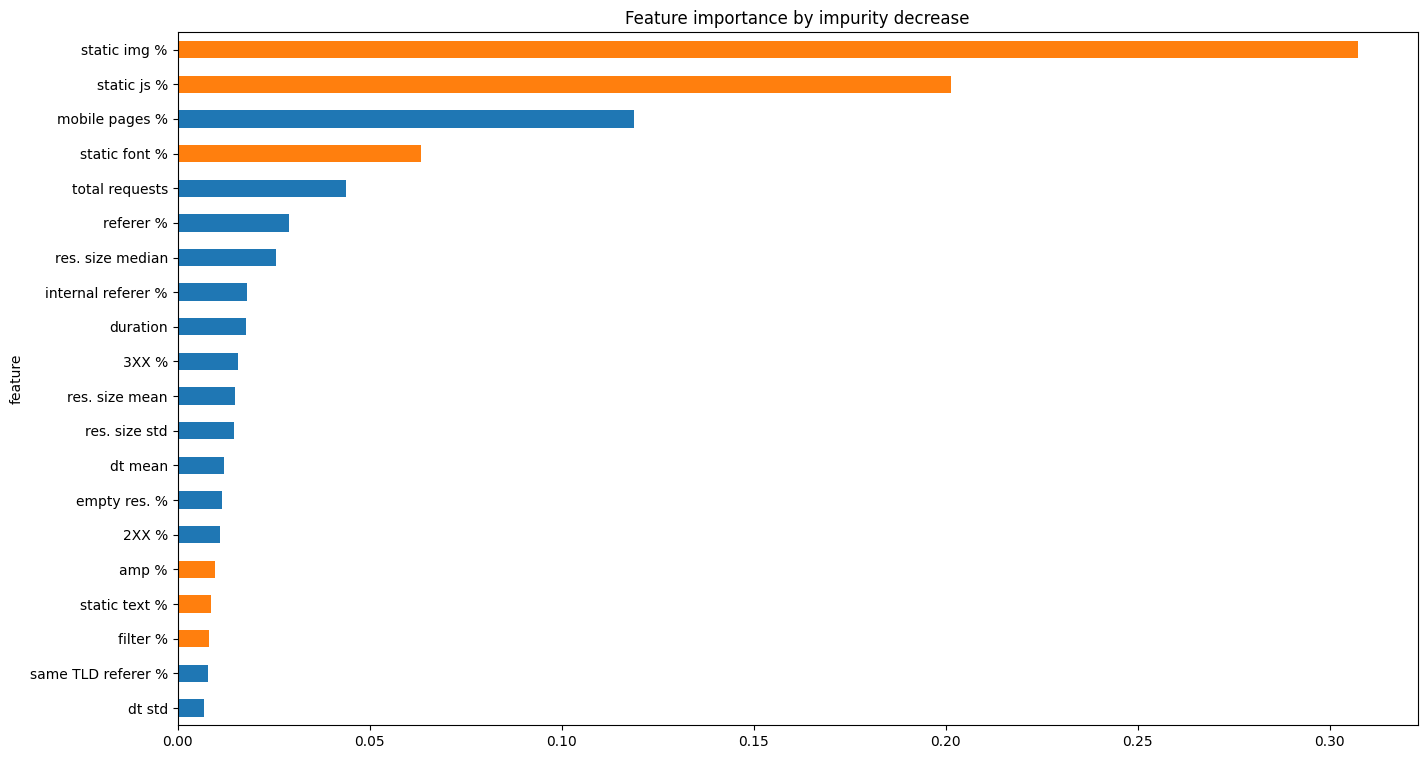

In [56]:
title = "Feature importance by impurity decrease"
sort_feature = "importance"
amt = 20

df_feat_importance.sort_values(by=sort_feature, inplace=True)
color = df_feat_importance['colors'].tail(amt)

df_feat_importance[sort_feature].tail(amt).plot(kind='barh', figsize=(16,9), title=title, xlabel="", color=color);

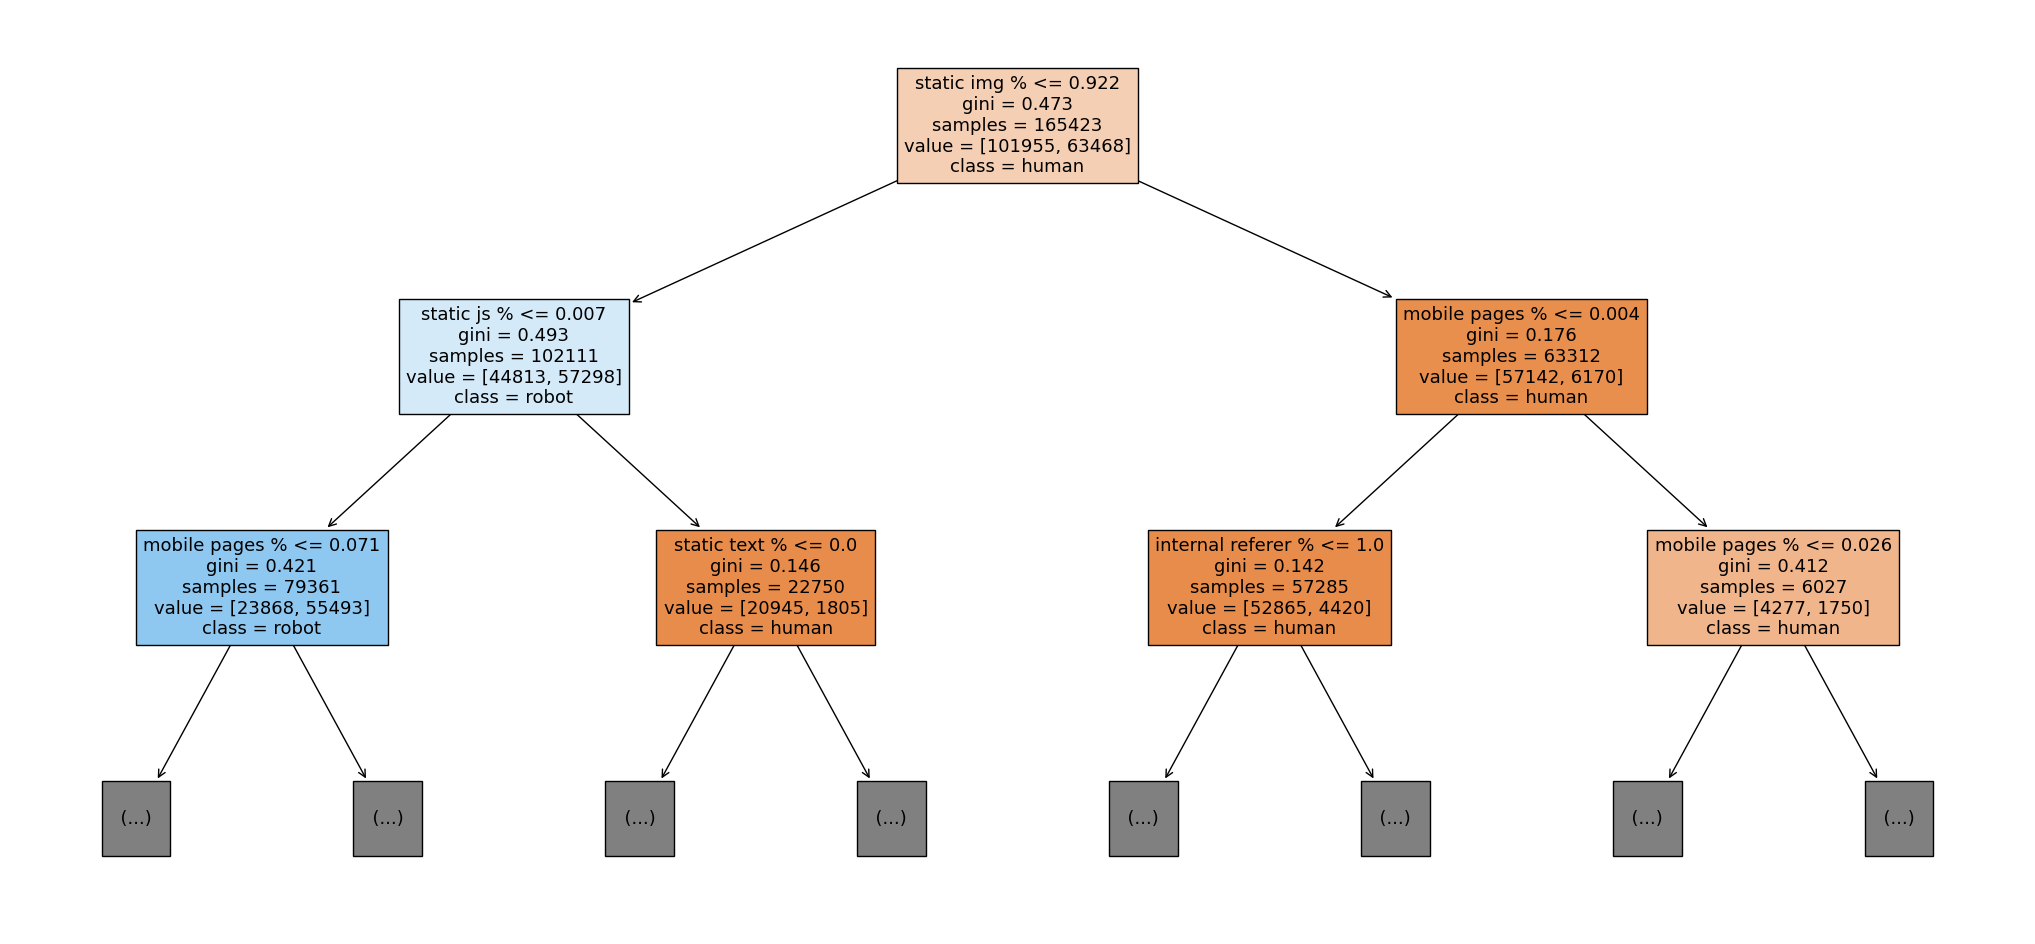

In [57]:
fig = plt.figure(figsize=(26,12))
plot_tree(tree, max_depth=2, feature_names=dataset_unscaled.columns, class_names=('human', 'robot'), filled=True);

##### Permutation Importance

In [58]:
from sklearn.inspection import permutation_importance

perm_tree = permutation_importance(tree, x_test, y_test, n_jobs=-1, random_state=42)
vstack_tree = np.vstack((dataset_unscaled.columns[:-1], perm_tree.importances_mean, perm_tree.importances_std)).T

In [59]:
df_perm_importance_tree = pd.DataFrame(vstack_tree, columns=('feature', 'mean importance', 'importance std'))
df_perm_importance_tree.set_index("feature", inplace=True)

df_perm_importance_tree.sort_values(by="mean importance", ascending=False, inplace=True)
df_perm_importance_tree.head(10)

,mean importance,importance std
feature,,
static img %,0.32698,0.002724
mobile pages %,0.221578,0.00167
internal referer %,0.130124,0.000638
referer %,0.087388,0.001616
total requests,0.074688,0.000706
dt mean,0.074345,0.001729
dt median,0.060954,0.000524
static font %,0.05338,0.001048
mobile UA %,0.050469,0.000553


In [60]:
df_perm_importance_tree['navigational features'] = df_perm_importance_tree.loc[nav_features]['mean importance']
df_perm_importance_tree['ecommerce features'] = df_perm_importance_tree.loc[ecomm_features]['mean importance']
df_perm_importance_tree['colors'] = np.where(df_perm_importance_tree['navigational features'].isna(), 'tab:orange', 'tab:blue')

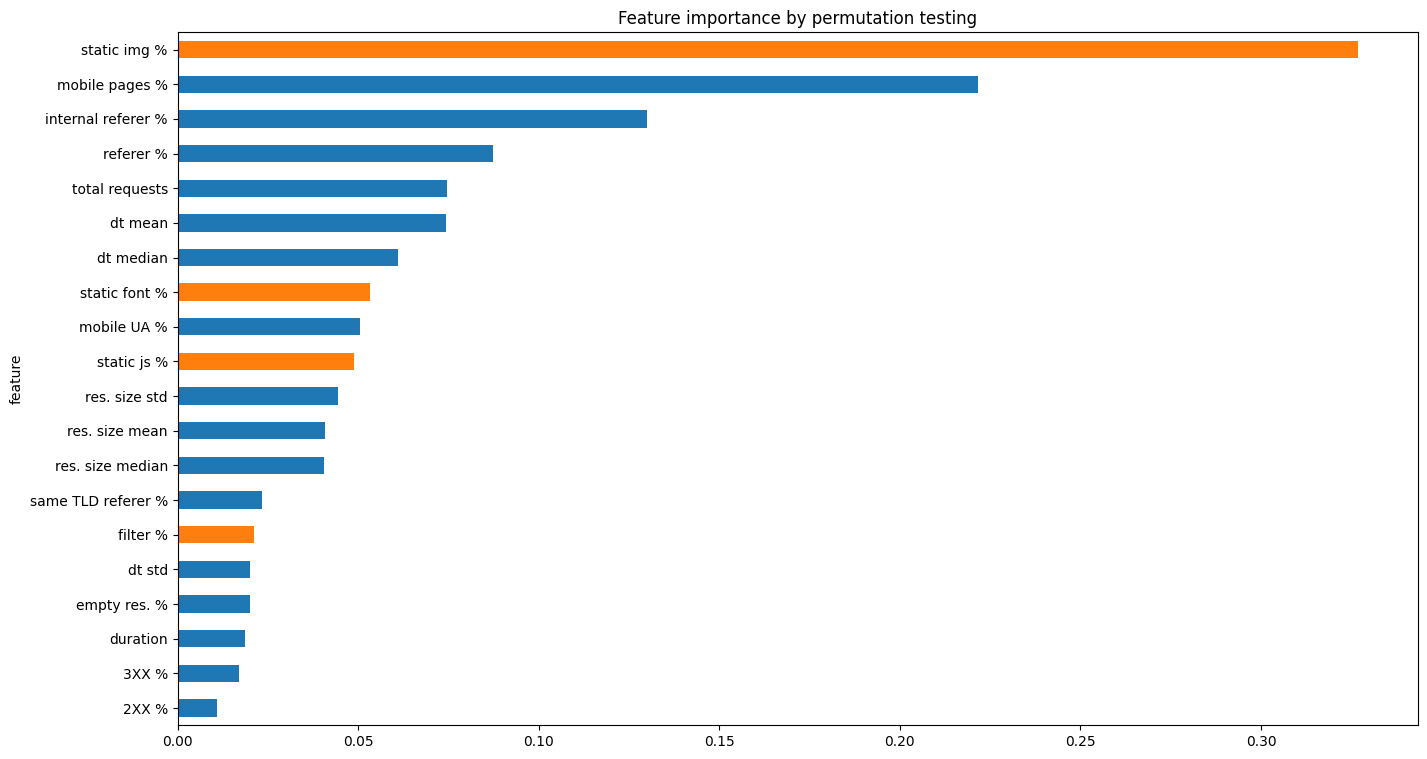

In [61]:
title = "Feature importance by permutation testing"
sort_feature = "mean importance"
amt = 20

df_perm_importance_tree.sort_values(by=sort_feature, inplace=True)
color = df_perm_importance_tree['colors'].tail(amt)

df_perm_importance_tree[sort_feature].tail(amt).plot(kind='barh', figsize=(16,9), title=title, xlabel="", color=color);

##### Lime

In [62]:
from lime.lime_tabular import LimeTabularExplainer

features = list(dataset_unscaled.columns[:-1])
explainer = LimeTabularExplainer(X_train.values, training_labels=Y_train, feature_names=features, class_names=('human', 'robot'), random_state=42)

In [63]:
i = 42 # np.random.randint(0, x_test.shape[0])
exp_tree = explainer.explain_instance(x_test.iloc[i], tree.predict_proba)
y_test.iloc[i]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


ROBOT    1
Name: 13942, dtype: int64

In [64]:
exp_tree.show_in_notebook()

##### Shap

In [65]:
import shap

exp_tree = shap.TreeExplainer(tree)
shap_values_tree = exp_tree.shap_values(x_test)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


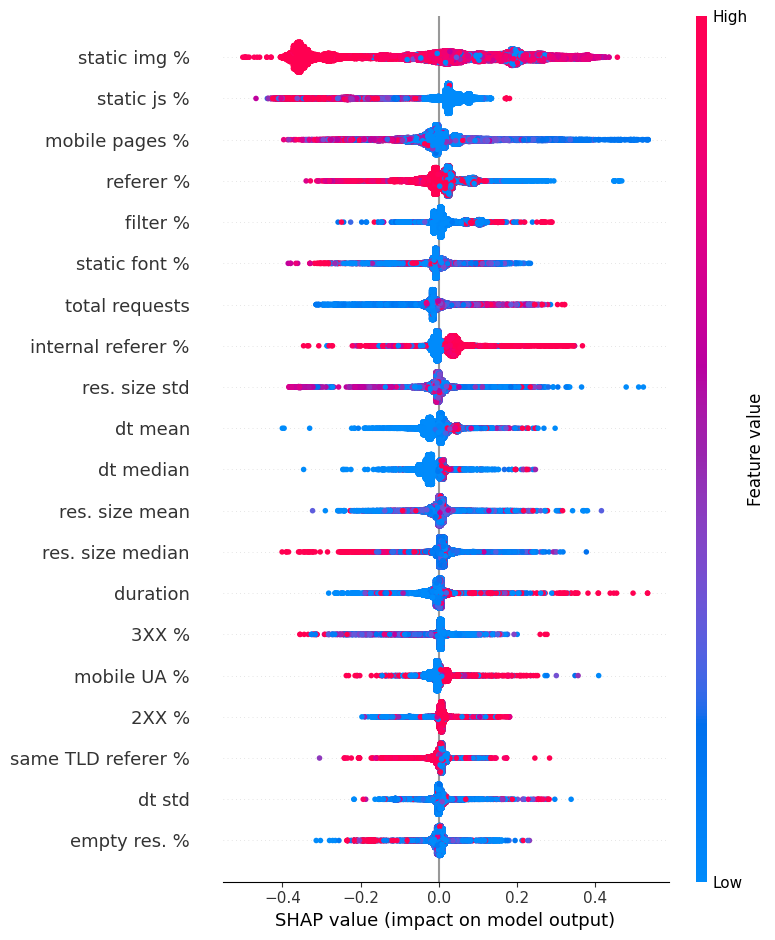

In [66]:
shap.summary_plot(shap_values_tree[1], x_test)

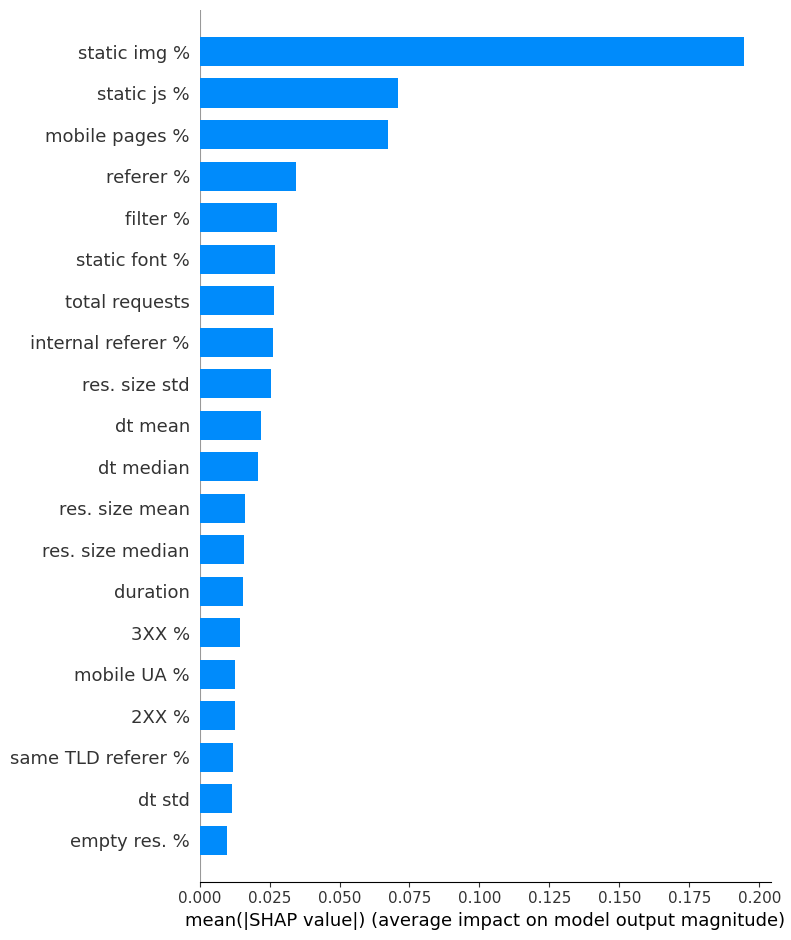

In [67]:
shap.summary_plot(shap_values_tree[1], x_test, plot_type="bar")

### Removing e-commerce features

In [68]:
start_index = dataset_unscaled.columns.get_loc("homepage %")
end_index = dataset_unscaled.columns.get_loc("ping %")
ecomm_features = dataset_unscaled.iloc[:, start_index:end_index].columns
dataset_unscaled_noncommerce = dataset_unscaled.drop(columns=ecomm_features)

In [69]:
X_train, x_test, Y_train, y_test = split(dataset_unscaled_noncommerce)

In [70]:
param_grid = {
    'max_depth': [30, 35, 40],
    'min_samples_split': [35, 40, 45, 50]
}

model = DecisionTreeClassifier(random_state=42)
grid = GridSearchCV(model, param_grid, scoring='precision', n_jobs=-1, cv=5, verbose=1)
grid.fit(X_train, Y_train);

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [71]:
display_grid_results(grid, param_grid.keys())

,param_max_depth,param_min_samples_split,mean_fit_time,std_fit_time,mean_test_score,std_test_score
0,30,50,5.265882,0.699073,0.863850,0.003694
1,35,50,5.365493,0.853641,0.862643,0.004341
2,30,45,5.126246,0.476711,0.862302,0.004590
3,40,50,5.398801,0.685376,0.861816,0.003920
4,35,45,5.025114,0.951799,0.860931,0.004855
5,30,40,5.107889,0.692259,0.860880,0.004255
6,40,45,5.709908,1.082549,0.860302,0.005091
7,30,35,5.426160,1.107284,0.859600,0.004048
8,35,40,5.416894,1.166656,0.858812,0.004709
9,40,40,5.129273,0.995187,0.858460,0.005052


In [72]:
tree = grid.best_estimator_
print(classification_report(y_test, tree.predict(x_test), target_names=('human', 'robot'), digits=4))

              precision    recall  f1-score   support

       human     0.8902    0.9235    0.9066     25636
       robot     0.8672    0.8143    0.8399     15720

    accuracy                         0.8820     41356
   macro avg     0.8787    0.8689    0.8733     41356
weighted avg     0.8815    0.8820    0.8813     41356



### Reduced datasets

#### Duration: 14 seconds max

In [73]:
X_train, x_test, Y_train, y_test = split(dataset_dur14)

In [74]:
param_grid = {
    'max_depth': [14, 16, 18, 20],
    'min_samples_split': [2, 4, 8, 10]
}

model = DecisionTreeClassifier(random_state=42)
grid = GridSearchCV(model, param_grid, scoring='precision', n_jobs=-1, cv=5, verbose=1)
grid.fit(X_train, Y_train);

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [75]:
display_grid_results(grid, param_grid.keys())

,param_max_depth,param_min_samples_split,mean_fit_time,std_fit_time,mean_test_score,std_test_score
0,16,10,1.236328,0.075465,0.894881,0.008242
1,16,8,0.667722,0.040036,0.893875,0.007628
2,14,8,0.610889,0.010159,0.889149,0.011029
3,14,10,0.610970,0.014001,0.888773,0.011028
4,14,4,0.612964,0.011118,0.888693,0.010673
5,16,4,0.643909,0.017711,0.886959,0.007508
6,14,2,0.964770,0.217074,0.882121,0.012264
7,18,10,0.670811,0.010717,0.881568,0.009279
8,16,2,0.655196,0.012844,0.880424,0.008000
9,18,8,0.685670,0.013298,0.876339,0.009054


In [76]:
tree = grid.best_estimator_
print(classification_report(y_true=y_test, y_pred=tree.predict(x_test), target_names=('human', 'robot')))

              precision    recall  f1-score   support

       human       0.92      0.98      0.95      7932
       robot       0.91      0.75      0.82      2490

    accuracy                           0.92     10422
   macro avg       0.92      0.86      0.88     10422
weighted avg       0.92      0.92      0.92     10422



#### Duration: 1 minute max

In [77]:
X_train, x_test, Y_train, y_test = split(dataset_dur60)

In [78]:
param_grid = {
    'max_depth': [20, 25, 30],
    'min_samples_split': [4, 8, 10, 12]
}

model = DecisionTreeClassifier(random_state=42)
grid = GridSearchCV(model, param_grid, scoring='precision', n_jobs=-1, cv=5, verbose=1)
grid.fit(X_train, Y_train);

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [79]:
display_grid_results(grid, param_grid.keys())

,param_max_depth,param_min_samples_split,mean_fit_time,std_fit_time,mean_test_score,std_test_score
0,20,12,1.614537,0.035979,0.899746,0.003637
1,20,10,2.505623,0.553617,0.895773,0.004667
2,20,8,1.657573,0.082277,0.893449,0.004381
3,25,12,2.163129,0.556323,0.890829,0.004996
4,30,12,1.953445,0.368285,0.887024,0.003782
5,20,4,1.658216,0.016911,0.886817,0.004891
6,25,10,1.750528,0.037626,0.886148,0.005585
7,25,8,2.410833,0.529963,0.883057,0.005622
8,30,10,2.525187,0.639811,0.881199,0.003483
9,30,8,1.766367,0.044553,0.875959,0.004097


In [80]:
tree = grid.best_estimator_
print(classification_report(y_true=y_test, y_pred=tree.predict(x_test), target_names=('human', 'robot')))

              precision    recall  f1-score   support

       human       0.93      0.96      0.94     12813
       robot       0.90      0.85      0.87      5995

    accuracy                           0.92     18808
   macro avg       0.92      0.90      0.91     18808
weighted avg       0.92      0.92      0.92     18808



# Pickle Model

In [83]:
import pickle

pickle.dump(tree , open('bot-detection.pk1' , 'wb'))
loaded_model = pickle.load(open('bot-detection.pk1' , 'rb'))
loaded_model_accuracy = loaded_model.score(x_test, y_test)
print(loaded_model_accuracy)

0.9218417694598043
